In [1]:
from sklearn.linear_model import LogisticRegression
from keras.layers import Input, Dense, Dropout
from keras.models import Model
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
import ggplot as gplt
from tools.mean_encoder import *
from sklearn.preprocessing import MinMaxScaler
import time
import seaborn as sns
from sklearn import neighbors
import matplotlib.pyplot as plt

C:\Users\S\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
C:\Users\S\Anaconda3\lib\site-packages\ggplot\utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
C:\Users\S\Anaconda3\lib\site-packages\ggplot\stats\smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
C:\Users\S\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use th

In [7]:
def unit_process_count(train_x, val_x):
    whole_set = [train_x.copy(), val_x.copy()]
    for i, table in enumerate(whole_set):
        count = table.groupby(["unit", "group_id"])["order_id"].count().reset_index()
        count.rename({"order_id": "unit_count"}, axis="columns", inplace=True)
        table = pd.merge(table, count, on=["unit", "group_id"], how="left")
        whole_set[i] = table.drop(columns=["order_id", "group_id"])
    return whole_set

In [8]:
def cat_data(x, y, cv):
    train_x, val_x = x[0].copy(), x[1].copy()
    train_y, val_y = y
    mean_enc_col = ["source1_unit"]
    train_x = mean_encoder(train_x, train_y, mean_enc_col, "deal_or_not", cv)
    val_x = test_set_encoder(train_x, train_y, val_x, mean_enc_col, "deal_or_not")

    drop_col = ['source1_source2', 'source1_unit', 'source2_unit',
           'source1_source2_unit', 'order_month', 'order_quarter', 'subline_area',
           'begin_month', 'begin_quarter', 'abroad_airport', 'home_airport',
           'abroad_hour', 'abroad_part_of_day', 'abroad_DoY', 'abroad_DoW',
           'abroad_DoM', 'home_DoW', 'home_DoM', 'home_DoY', 'home_hour',
           'home_part_of_day']
    drop_col += [x for x in train_x.columns if "prod_vec" in x]
    for table in [train_x, val_x]:
        table.drop(columns=drop_col, inplace=True)
        
    #and "DoY" not in col
    cat_feature = []
    key_words = ["source", "unit", "sub", "area", "order", "begin", "_airport",
                 "abroad", "home"]
    for i, col in enumerate(train_x.columns):
        for kw in key_words:
            if kw in col and "duration" not in col and "DoY" not in col and "target" not in col \
             and "accum" not in col and "_z" not in col and "count" not in col and "_id" not in col and i not in cat_feature:
                cat_feature.append(i)
    
    return (train_x, val_x, cat_feature)

In [9]:
def logistic_data(x, y, cv):
    train_x, val_x = x[0].copy(), x[1].copy()
    train_y, val_y = y
    drop_col = ['source1_source2', 'source1_unit', 'source2_unit',
       'source1_source2_unit', 'order_month', 'order_quarter', 'subline_area',
       'begin_month', 'begin_quarter', 'abroad_airport', 'home_airport',
       'abroad_hour', 'abroad_part_of_day', 'abroad_DoY', 'abroad_DoW',
       'abroad_DoM', 'home_DoW', 'home_DoM', 'home_DoY', 'home_hour',
       'home_part_of_day']
    drop_col += [x for x in train_x.columns if "prod_vec" in x]
    for table in [train_x, val_x]:
        table.drop(columns=drop_col, inplace=True)
        
    for table in [train_x, val_x]:
        table.replace([np.inf, -np.inf], np.nan, inplace=True)
        table.fillna(table.mean(), inplace=True)
    
    cat_feature = []
    key_words = ["source", "unit", "sub", "area", "order", "begin", "_airport",
                 "abroad", "home"]
    for i, col in enumerate(train_x.columns):
        for kw in key_words:
            if kw in col and "duration" not in col and "DoY" not in col and "target" not in col \
             and "accum" not in col and "_z" not in col and "count" not in col and "_id" not in col and i not in cat_feature:
                cat_feature.append(i)

    mean_enc_col = list(train_x.columns[cat_feature])
    train_x = mean_encoder(train_x, train_y, mean_enc_col, "deal_or_not", cv)
    val_x = test_set_encoder(train_x, train_y, val_x, mean_enc_col, "deal_or_not")
    
    #train_x, val_x = unit_process_count(train_x, val_x)
    scaler = MinMaxScaler()
    train_std = scaler.fit_transform(train_x)
    val_std = scaler.transform(val_x)
    
    return (train_std, val_std)

In [10]:
def dummy_rep(table, cat_feature):
    dummy = pd.get_dummies(table[cat_feature[0]])
    dummy.columns = [cat_feature[0] + "_" + str(i) for i in range(dummy.shape[1])]
    for col in cat_feature[1:]:
        dummy_tmp = pd.get_dummies(table[col])
        dummy_tmp.columns = [col + "_" + str(i) for i in range(dummy_tmp.shape[1])]
        dummy = pd.concat([dummy, dummy_tmp], axis=1)
    return pd.concat([table.drop(columns=cat_feature), dummy], axis=1)



def cat2dummy(train, test):
    train_x, val_x = train.copy(), test.copy()
    drop_col = ['source1_source2', 'source1_unit', 'source2_unit',
       'source1_source2_unit', 'order_month', 'order_quarter', 'subline_area',
       'begin_month', 'begin_quarter', 'abroad_airport', 'home_airport',
       'abroad_hour', 'abroad_part_of_day', 'abroad_DoY', 'abroad_DoW',
       'abroad_DoM', 'home_DoW', 'home_DoM', 'home_DoY', 'home_hour',
       'home_part_of_day']
    drop_col += [x for x in train_x.columns if "prod_vec" in x]
    for table in [train_x, val_x]:
        table.drop(columns=drop_col, inplace=True)
    cat_feature = []
    key_words = ["source", "unit", "sub", "area", "order", "begin", "_airport",
                 "abroad", "home"]
    for i, col in enumerate(train_x.columns):
        for kw in key_words:
            if kw in col and "duration" not in col and "DoY" not in col and "target" not in col \
             and "accum" not in col and "_z" not in col and "count" not in col and "_id" not in col and i not in cat_feature:
                cat_feature.append(i)
    whole_set = pd.concat([train_x, val_x])
    whole_set.index = list(range(whole_set.shape[0]))
    whole_dummy = dummy_rep(whole_set, whole_set.columns[cat_feature])
    train_dummy = whole_dummy.iloc[0:train_x.shape[0]]
    val_dummy = whole_dummy.iloc[train_x.shape[0]:]
    return (train_dummy, val_dummy)

def fnn_data(x, y):
    train_x, val_x = x[0].copy(), x[1].copy()
    train_y, val_y = y
    
    assert np.mean(train_x.columns == val_x.columns)
    for table in [train_x, val_x]:
        table.replace([np.inf, -np.inf], np.nan, inplace=True)
        table.fillna(train_x.mean(), inplace=True)
    
    #train_x, val_x = unit_process_count(train_x, val_x)
    scaler = MinMaxScaler()
    train_dummy_std = scaler.fit_transform(train_x)
    val_dummy_std = scaler.transform(val_x)
    return (train_dummy_std, val_dummy_std)

In [11]:
def fm_data(x, y):
    train_x, val_x = x[0].copy(), x[1].copy()
    train_y, val_y = y
    drop_col = ['source1_source2', 'source1_unit', 'source2_unit',
       'source1_source2_unit', 'order_month', 'order_quarter', 'subline_area',
       'begin_month', 'begin_quarter', 'abroad_airport', 'home_airport',
       'abroad_hour', 'abroad_part_of_day', 'abroad_DoY', 'abroad_DoW',
       'abroad_DoM', 'home_DoW', 'home_DoM', 'home_DoY', 'home_hour',
       'home_part_of_day']
    drop_col += [x for x in train_x.columns if "prod_vec" in x]
    for table in [train_x, val_x]:
        table.drop(columns=drop_col, inplace=True)
    
    for table in [train_x, val_x]:
        table.replace([np.inf, -np.inf], np.nan, inplace=True)
        table.fillna(table.mean(), inplace=True)
        
    cat_feature = []
    key_words = ["source", "unit", "sub", "area", "order", "begin", "_airport",
                 "abroad", "home"]
    for i, col in enumerate(train_x.columns):
        for kw in key_words:
            if kw in col and "duration" not in col and "DoY" not in col and "target" not in col \
             and "accum" not in col and "_z" not in col and "count" not in col and "_id" not in col and i not in cat_feature:
                cat_feature.append(i)
    train_x["Label"] = train_y
    val_x["Label"] = val_y
    return (train_x, val_x)

In [12]:
def neural_net(hidden_node, level):
    input_layer = Input(shape=(366, ))
    hidden = Dense(hidden_node, activation="relu")(input_layer)
    for i in range(level-1):
        hidden = Dropout(0.5)(hidden)
        hidden = Dense(hidden_node, activation="relu")(hidden)
    output_layer = Dense(1, activation="sigmoid")(hidden)
    nn = Model(input_layer, output_layer)
    nn.compile(optimizer="adam", loss="binary_crossentropy")
    return nn

In [13]:
train_set = pd.read_csv("dataset/train_val/training_set.csv")
test_set = pd.read_csv("dataset/train_val/testing_set.csv")

train_set["group_id"] = train_set["group_id"].astype(str)

group_price_days = pd.read_csv("./feature_extraction/features/group_days_price.csv")
train_set = pd.merge(train_set, group_price_days, on="group_id", how="left")
test_set = pd.merge(test_set, group_price_days, on="group_id", how="left")

whole_set = [train_set, test_set]
for col in ["unit"]:
    for i, table in enumerate(whole_set):
        count = table.groupby([col, "group_id"])["order_id"].count().reset_index()
        count.rename({"order_id": col + "_count"}, axis="columns", inplace=True)
        table = pd.merge(table, count, on=[col, "group_id"], how="left")
        whole_set[i] = table



train_set, test_set = whole_set
        

y_train = train_set["deal_or_not"]
for table in [train_set, test_set]:
    table.drop(columns=["deal_or_not", "group_id", "order_id"], inplace=True)
    
train_set["accum_count_ratio"] = train_set["accum_order"] / train_set["group_id_count"]
test_set["accum_count_ratio"] = test_set["accum_order"] / test_set["group_id_count"]

train_x, val_x, train_y, val_y = train_test_split(train_set, y_train, random_state=104702016,
                                                 shuffle=True, stratify=y_train)


#train_x, C_x, train_y, C_y = train_test_split(train_set, y_train, random_state=104702016,
#                                              shuffle=True, stratify=y_train, test_size=0.1)
#A_x, B_x, A_y, B_y = train_test_split(train_x, train_y, random_state=104702016, test_size=70000,
#                                      shuffle=True, stratify=train_y)

cv = StratifiedKFold(5, shuffle=True, random_state=851206)
train_dummy, test_dummy = cat2dummy(train_set, test_set)
train_dummy.replace([np.inf, -np.inf], np.nan, inplace=True)
test_dummy.replace([np.inf, -np.inf], np.nan, inplace=True)

In [21]:
# KNN parameter tuning
"""all_auc = np.zeros((5, 30))
knn_cv = StratifiedKFold(5, shuffle=True, random_state=104702016)
count = 0
for tr_ind, val_ind in knn_cv.split(y_train, y_train):
    x_tr, y_tr = train_set.iloc[tr_ind], y_train[tr_ind]
    x_val, y_val = train_set.iloc[val_ind], y_train[val_ind]
    x_tr, x_val = logistic_data((x_tr, x_val), (y_tr, y_val), cv)
    for neigh in range(1, 31):
        print("cv:", count+1, ", n_neighs:", neigh)
        clf = neighbors.KNeighborsClassifier(n_jobs=-1, n_neighbors=neigh)
        clf.fit(x_tr, y_tr)
        clf_pred = clf.predict_proba(x_val)
        cur_auc = roc_auc_score(y_val, clf_pred[:, 1])
        all_auc[count, neigh-1] = cur_auc
    count += 1"""
all_auc = np.zeros((1, 30))
knn_tr_x, knn_val_x = logistic_data((train_x, val_x), (train_y, val_y), cv)
for neigh in range(1, 31):
    print("n_neighs:", neigh)
    clf = neighbors.KNeighborsClassifier(n_jobs=-1, n_neighbors=neigh)
    clf.fit(knn_tr_x, train_y)
    clf_pred = clf.predict_proba(knn_val_x)
    cur_auc = roc_auc_score(val_y, clf_pred[:, 1])
    all_auc[0, neigh-1] = cur_auc
    
all_auc2 = np.zeros((1, 60))
all_auc2[0, 0:30] = all_auc
for neigh in range(31, 61):
    print("n_neighs:", neigh)
    clf = neighbors.KNeighborsClassifier(n_jobs=-1, n_neighbors=neigh)
    clf.fit(knn_tr_x, train_y)
    clf_pred = clf.predict_proba(knn_val_x)
    cur_auc = roc_auc_score(val_y, clf_pred[:, 1])
    all_auc2[0, neigh-1] = cur_auc
# the best k is 54

n_neighs: 31
n_neighs: 32
n_neighs: 33
n_neighs: 34
n_neighs: 35
n_neighs: 36
n_neighs: 37
n_neighs: 38
n_neighs: 39
n_neighs: 40
n_neighs: 41
n_neighs: 42
n_neighs: 43
n_neighs: 44
n_neighs: 45
n_neighs: 46
n_neighs: 47
n_neighs: 48
n_neighs: 49
n_neighs: 50
n_neighs: 51
n_neighs: 52
n_neighs: 53
n_neighs: 54
n_neighs: 55
n_neighs: 56
n_neighs: 57
n_neighs: 58
n_neighs: 59
n_neighs: 60


In [17]:
x_tr.columns[cat_feature]

Index(['unit', 'people_amount', 'order_year', 'sub_line', 'days', 'price',
       'flight_time_mean'],
      dtype='object')

In [16]:
param = {"objective": "binary:logistic",
             "max_depth": 3,
             "eta": 0.05,
             "n_estimators": 500,
             "silent": True,
             #"subsample": 0.8,
             "tree_method": "gpu_hist",
             "seed": 104702016
             }
xgb_cv = StratifiedKFold(5, shuffle=True, random_state=104702016)
xgb_val_auc = []
for tr_ind, val_ind in xgb_cv.split(y_train, y_train):
    x_tr, y_tr = train_set.iloc[tr_ind], y_train.iloc[tr_ind]
    x_val, y_val = train_set.iloc[val_ind], y_train.iloc[val_ind]
    x_tr, x_val, cat_feature = cat_data((x_tr, x_val), (y_tr, y_val), cv)
    xgb = XGBClassifier(**param)
    xgb.fit(x_tr, y_tr)
    tr_auc = roc_auc_score(y_tr, xgb.predict_proba(x_tr)[:, 1])
    val_auc = roc_auc_score(y_val, xgb.predict_proba(x_val)[:, 1])
    print("train auc:", tr_auc, ", val auc:", val_auc)
    xgb_val_auc.append(val_auc)
print("mean of val auc:", np.mean(xgb_val_auc))


C:\Users\S\travel_data\tools\mean_encoder.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  x_val[colname] = means


train auc: 0.7606368600189023 , val auc: 0.7430660032363209


C:\Users\S\travel_data\tools\mean_encoder.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  x_val[colname] = means


train auc: 0.762400374480795 , val auc: 0.7364692474519865


C:\Users\S\travel_data\tools\mean_encoder.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  x_val[colname] = means


KeyboardInterrupt: 

In [17]:
def neural_net(hidden_node, level):
    input_layer = Input(shape=(369, ))
    hidden = Dense(hidden_node, activation="relu")(input_layer)
    for i in range(level-1):
        hidden = Dropout(0.5)(hidden)
        hidden = Dense(hidden_node, activation="relu")(hidden)
    output_layer = Dense(1, activation="sigmoid")(hidden)
    nn = Model(input_layer, output_layer)
    nn.compile(optimizer="adam", loss="binary_crossentropy")
    return nn


nn_cv = StratifiedKFold(5, shuffle=True, random_state=104702016)
nn_val_auc = []
for tr_ind, val_ind in nn_cv.split(y_train, y_train):
    x_tr, y_tr = train_dummy.iloc[tr_ind], y_train.iloc[tr_ind]
    x_val, y_val = train_dummy.iloc[val_ind], y_train.iloc[val_ind]
    x_tr, x_val = fnn_data((x_tr, x_val), (y_tr, y_val))
    deep_nn = neural_net(128, 3)
    deep_nn.fit(x_tr, y_tr, epochs=20, batch_size=256, verbose=1, validation_data=(x_val, y_val))
    tr_auc = roc_auc_score(y_tr, deep_nn.predict(x_tr)[:, 0])
    val_auc = roc_auc_score(y_val, deep_nn.predict(x_val)[:, 0])
    print("train auc:", tr_auc, ", val auc:", val_auc)
    nn_val_auc.append(val_auc)
print("mean of val auc:", np.mean(nn_val_auc))

Train on 237615 samples, validate on 59405 samples
Epoch 1/20
237615/237615 [==============================] - 8s 33us/step - loss: 0.4744 - val_loss: 0.4495
Epoch 2/20
237615/237615 [==============================] - 7s 29us/step - loss: 0.4491 - val_loss: 0.4342
Epoch 3/20
237615/237615 [==============================] - 7s 31us/step - loss: 0.4391 - val_loss: 0.4283
Epoch 4/20
237615/237615 [==============================] - 7s 30us/step - loss: 0.4341 - val_loss: 0.4274
Epoch 5/20
237615/237615 [==============================] - 7s 31us/step - loss: 0.4316 - val_loss: 0.4252
Epoch 6/20
237615/237615 [==============================] - 8s 32us/step - loss: 0.4295 - val_loss: 0.4236
Epoch 7/20
237615/237615 [==============================] - 7s 28us/step - loss: 0.4281 - val_loss: 0.4224
Epoch 8/20
237615/237615 [==============================] - 7s 30us/step - loss: 0.4262 - val_loss: 0.4222
Epoch 9/20
237615/237615 [==============================] - 7s 30us/step - loss: 0.4248 - val

KeyboardInterrupt: 

In [36]:
nn_cv = StratifiedKFold(5, shuffle=True, random_state=104702016)
nn_val_auc2 = []
for tr_ind, val_ind in nn_cv.split(y_train, y_train):
    x_tr, y_tr = train_dummy.iloc[tr_ind], y_train.iloc[tr_ind]
    x_val, y_val = train_dummy.iloc[val_ind], y_train.iloc[val_ind]
    x_tr, x_val = fnn_data((x_tr, x_val), (y_tr, y_val))
    shallow_nn = neural_net(128, 1)
    shallow_nn.fit(x_tr, y_tr, epochs=10, batch_size=256, verbose=0)
    tr_auc = roc_auc_score(y_tr, shallow_nn.predict(x_tr)[:, 0])
    val_auc = roc_auc_score(y_val, shallow_nn.predict(x_val)[:, 0])
    print("train auc:", tr_auc, ", val auc:", val_auc)
    nn_val_auc2.append(val_auc)
print("mean of val auc:", np.mean(nn_val_auc2))

train auc: 0.7633172905294262 , val auc: 0.7244308787131372
train auc: 0.76512661986889 , val auc: 0.7194750089829699
train auc: 0.7653012975783127 , val auc: 0.7217732289547848
train auc: 0.7648136724755874 , val auc: 0.7214799021081949
train auc: 0.7617470142740819 , val auc: 0.7220777416686712
mean of val auc: 0.7218473520855516


In [18]:
train_set.columns

Index(['source_1', 'source_2', 'unit', 'people_amount', 'source1_source2',
       'source1_unit', 'source2_unit', 'source1_source2_unit', 'order_year',
       'order_month', 'order_DoY', 'order_quarter', 'sub_line', 'area', 'days',
       'price', 'day_price', 'subline_area', 'begin_month', 'begin_DoY',
       'begin_DoW', 'begin_quarter', 'prod_vec_1', 'prod_vec_2', 'prod_vec_3',
       'prod_vec_4', 'prod_vec_5', 'prod_vec_6', 'prod_vec_7', 'prod_vec_8',
       'prod_vec_9', 'prod_vec_10', 'prod_vec_11', 'prod_vec_12',
       'prod_vec_13', 'prod_vec_14', 'prod_vec_15', 'prod_vec_16',
       'prod_vec_17', 'prod_vec_18', 'prod_vec_19', 'prod_vec_20',
       'flight_time_sum', 'flight_time_mean', 'flight_time_std',
       'flight_time_min', 'flight_time_max', 'flight_dist_sum',
       'flight_dist_mean', 'flight_dist_std', 'flight_dist_min',
       'flight_dist_max', 'time_dist_sum', 'time_dist', 'time_dist_std',
       'time_dist_min', 'time_dist_max', 'airport_amount', 'abroad_airpo

In [9]:
stack_cv = StratifiedKFold(5, shuffle=True, random_state=104702016)

cat_params = {
    "learning_rate": 0.05,
    "iterations": 500,
    "random_seed": 104702016,
    "eval_metric": 'AUC'
}

xgb_params = {
    "objective": "binary:logistic",
    "max_depth": 3,
    "eta": 0.05,
    "n_estimators": 800,
    "silent": True,
    "tree_method": "gpu_hist",
    "seed": 104702016
}


train_meta = np.zeros((train_set.shape[0], 6))
count = 1
for tr_ind, val_ind in stack_cv.split(y_train, y_train):
    print("cv:", count)
    x_tr, y_tr = train_set.iloc[tr_ind], y_train[tr_ind]
    x_val, y_val = train_set.iloc[val_ind], y_train[val_ind]
    cat_tr_x, cat_val_x, cat_feature = cat_data((x_tr, x_val), (y_tr, y_val), cv)
    log_tr_x, log_val_x = logistic_data((x_tr, x_val), (y_tr, y_val), cv)
    knn_tr_x, knn_val_x = logistic_data((x_tr, x_val), (y_tr, y_val), cv)
    
    cat_cat = CatBoostClassifier(**cat_params)
    cat_cat.fit(cat_tr_x, y_tr, cat_features=cat_feature, logging_level='Silent')
    train_meta[val_ind, 0] = cat_cat.predict_proba(cat_val_x)[:, 1]
    
    log_reg = LogisticRegression(class_weight="balanced")
    log_reg.fit(log_tr_x, y_tr)
    train_meta[val_ind, 1] = log_reg.predict_proba(log_val_x)[:, 1]
    
    knn = neighbors.KNeighborsClassifier(n_jobs=16, n_neighbors=54)
    knn.fit(knn_tr_x, y_tr)
    train_meta[val_ind, 2] = knn.predict_proba(knn_val_x)[:, 1]
    
    xgb = XGBClassifier(**xgb_params)
    xgb.fit(cat_tr_x, y_tr)
    train_meta[val_ind, 3] = xgb.predict_proba(cat_val_x)[:, 1]
    
    x_tr, y_tr = train_dummy.iloc[tr_ind], y_train.iloc[tr_ind]
    x_val, y_val = train_dummy.iloc[val_ind], y_train.iloc[val_ind]
    x_tr, x_val = fnn_data((x_tr, x_val), (y_tr, y_val))
    
    deep_nn = neural_net(128, 3)
    deep_nn.fit(x_tr, y_tr, epochs=20, batch_size=256, verbose=0)
    train_meta[val_ind, 4] = deep_nn.predict(x_val)[:, 0]
    
    shallow_nn = neural_net(128, 1)
    shallow_nn.fit(x_tr, y_tr, epochs=10, batch_size=256, verbose=0)
    train_meta[val_ind, 5] = shallow_nn.predict(x_val)[:, 0]

    count += 1
#train_meta = pd.DataFrame(train_meta, columns=["cat_pred", "log_pred", "knn_pred", "xgb_pred"])
#train_meta.to_csv("train_meta_features.csv", encoding="utf-8", index=False)

cv: 1


C:\Users\S\travel_data\tools\mean_encoder.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  x_val[colname] = means


cv: 2


C:\Users\S\travel_data\tools\mean_encoder.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  x_val[colname] = means


cv: 3


C:\Users\S\travel_data\tools\mean_encoder.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  x_val[colname] = means


cv: 4


C:\Users\S\travel_data\tools\mean_encoder.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  x_val[colname] = means


cv: 5


C:\Users\S\travel_data\tools\mean_encoder.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  x_val[colname] = means


In [38]:
stack_cv = StratifiedKFold(5, shuffle=True, random_state=104702016)

nn_train_meta = np.zeros((train_set.shape[0], 2))
count = 0
for tr_ind, val_ind in stack_cv.split(y_train, y_train):
    print("cv:", count)
    x_tr, y_tr = train_dummy.iloc[tr_ind], y_train.iloc[tr_ind]
    x_val, y_val = train_dummy.iloc[val_ind], y_train.iloc[val_ind]
    x_tr, x_val = fnn_data((x_tr, x_val), (y_tr, y_val))
    
    deep_nn = neural_net(128, 3)
    deep_nn.fit(x_tr, y_tr, epochs=20, batch_size=256, verbose=0)
    nn_train_meta[val_ind, 0] = deep_nn.predict(x_val)[:, 0]
    
    shallow_nn = neural_net(128, 1)
    shallow_nn.fit(x_tr, y_tr, epochs=10, batch_size=256, verbose=0)
    nn_train_meta[val_ind, 1] = shallow_nn.predict(x_val)[:, 0]
    count += 1
train_meta = pd.read_csv("train_meta_features.csv")
train_meta["nn3_pred"] = nn_train_meta[:, 0]
train_meta["nn1_pred"] = nn_train_meta[:, 1]
train_meta.to_csv("train_meta_features.csv", encoding="utf-8", index=False)

cv: 0
cv: 1
cv: 2
cv: 3
cv: 4


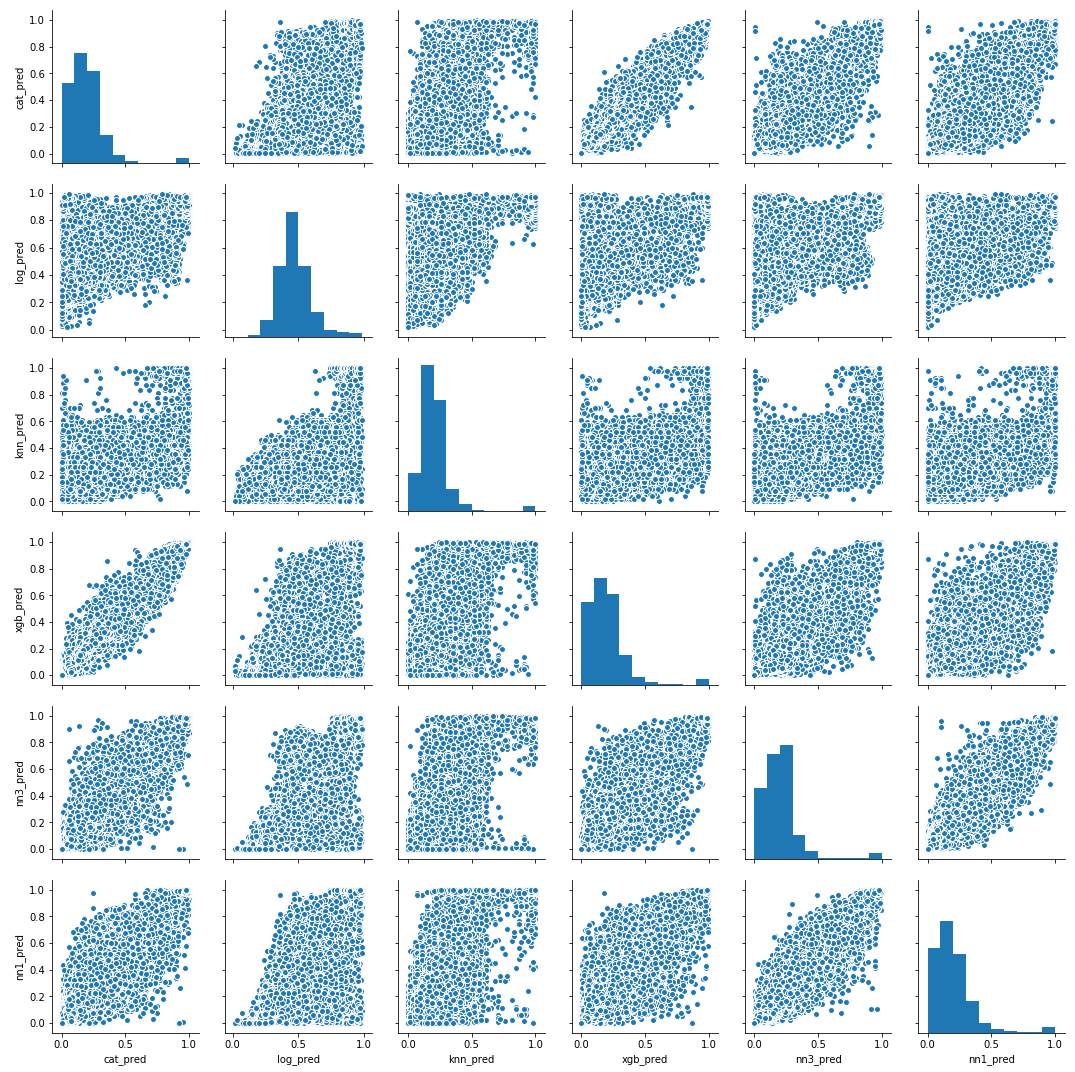

In [10]:
train_meta = pd.DataFrame(train_meta, columns=["cat_pred", "log_pred", "knn_pred", "xgb_pred", "nn3_pred", "nn1_pred"])
train_meta.to_csv("train_meta_features.csv", encoding="utf-8", index=False)
sns.pairplot(train_meta)

In [3]:
train_meta = pd.read_csv("train_meta_features.csv")

In [37]:
for i in range(4):
    for j in range(i+1, 4):
        pred1 = train_meta.columns[i]
        pred2 = train_meta.columns[j]
        train_meta[pred1.split("_")[0] + "_" + pred2.split("_")[0] + "_diff"] = train_meta[pred1] - train_meta[pred2]

In [33]:
# use logistic regression to be meta model
stack_log_cv = StratifiedKFold(5, shuffle=True, random_state=123456)
log_val_auc = []
for tr_ind, val_ind in stack_log_cv.split(y_train, y_train):
    x_tr, y_tr = train_meta.iloc[tr_ind], y_train.iloc[tr_ind]
    x_val, y_val = train_meta.iloc[val_ind], y_train.iloc[val_ind]
    stack_log = LogisticRegression(C=0.01, class_weight="balanced")
    stack_log.fit(x_tr, y_tr)
    tr_auc = roc_auc_score(y_tr, stack_log.predict_proba(x_tr)[:, 1])
    val_auc = roc_auc_score(y_val, stack_log.predict_proba(x_val)[:, 1])
    print("train auc:", tr_auc, ", val auc:", val_auc)
    log_val_auc.append(val_auc)
print("mean of val auc:", np.mean(log_val_auc))

train auc: 0.7548198440772946 , val auc: 0.7505237660267401
train auc: 0.7541990264521677 , val auc: 0.7525099389264708
train auc: 0.7535108242238663 , val auc: 0.755614065405402
train auc: 0.7539203725645949 , val auc: 0.7539887139216528
train auc: 0.7532226034392528 , val auc: 0.7569355662093402
mean of val auc: 0.7539144100979212


In [62]:
roc_auc_score(y_train, train_meta.mean(axis=1))

0.7342912680413243

In [56]:
# use xgboost to be meta model
param = {"objective": "binary:logistic",
             "max_depth": 2,
             "eta": 0.05,
             "n_estimators": 500,
             "silent": True,
             "tree_method": "gpu_hist",
             "seed": 104702016
             }
stack_xgb_cv = StratifiedKFold(5, shuffle=True, random_state=123456)
xgb_val_auc = []
for tr_ind, val_ind in stack_xgb_cv.split(y_train, y_train):
    x_tr, y_tr = train_meta.iloc[tr_ind], y_train.iloc[tr_ind]
    x_val, y_val = train_meta.iloc[val_ind], y_train.iloc[val_ind]
    stack_xgb = XGBClassifier(**param)
    stack_xgb.fit(x_tr, y_tr)
    tr_auc = roc_auc_score(y_tr, stack_xgb.predict_proba(x_tr)[:, 1])
    val_auc = roc_auc_score(y_val, stack_xgb.predict_proba(x_val)[:, 1])
    print("train auc:", tr_auc, ", val auc:", val_auc)
    xgb_val_auc.append(val_auc)
print("mean of val auc:", np.mean(xgb_val_auc))

train auc: 0.7454438333252529 , val auc: 0.7382466233229983
train auc: 0.7445990225081924 , val auc: 0.7411959674762751
train auc: 0.7439950305298668 , val auc: 0.7440791177711664
train auc: 0.7445502831426904 , val auc: 0.7418110405609859
train auc: 0.7437952861742284 , val auc: 0.7448032970482624
mean of val auc: 0.7420272092359377


In [57]:
# use catboost to be meta model
cat_params = {
    "learning_rate": 0.05,
    "iterations": 500,
    "random_seed": 104702016,
    "eval_metric": 'AUC',
    "logging_level": "Silent",
    "depth":2
}

stack_cat_cv = StratifiedKFold(5, shuffle=True, random_state=123456)
cat_val_auc = []
for tr_ind, val_ind in stack_xgb_cv.split(y_train, y_train):
    x_tr, y_tr = train_meta.iloc[tr_ind], y_train.iloc[tr_ind]
    x_val, y_val = train_meta.iloc[val_ind], y_train.iloc[val_ind]
    stack_cat = CatBoostClassifier(**cat_params)
    stack_cat.fit(x_tr, y_tr)
    tr_auc = roc_auc_score(y_tr, stack_cat.predict_proba(x_tr)[:, 1])
    val_auc = roc_auc_score(y_val, stack_cat.predict_proba(x_val)[:, 1])
    print("train auc:", tr_auc, ", val auc:", val_auc)
    cat_val_auc.append(val_auc)
print("mean of val auc:", np.mean(cat_val_auc))

train auc: 0.7442905733793531 , val auc: 0.7383776245562814
train auc: 0.743610320291793 , val auc: 0.7413177166792306
train auc: 0.7427592201288011 , val auc: 0.7447952542524493
train auc: 0.7433310711376993 , val auc: 0.7420397143942151
train auc: 0.7425807355087808 , val auc: 0.7448777014823124
mean of val auc: 0.7422816022728977


In [58]:
# use perceptron to be meta model
input_layer = Input(shape=(4, ))
hidden = Dense(4, activation="relu")(input_layer)
#hidden = Dense(5, activation="relu")(hidden)
output_layer = Dense(1, activation="sigmoid")(hidden)
stack_perceptron = Model(input_layer, output_layer)
stack_perceptron.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

stack_perceptron_cv = StratifiedKFold(5, shuffle=True, random_state=123456)
perceptron_val_auc = []
for tr_ind, val_ind in stack_perceptron_cv.split(y_train, y_train):
    x_tr, y_tr = train_meta.iloc[tr_ind], y_train.iloc[tr_ind]
    x_val, y_val = train_meta.iloc[val_ind], y_train.iloc[val_ind]
    stack_perceptron.reset_states()
    stack_perceptron.fit(x_tr, y_tr, epochs=10, batch_size=256, shuffle=True, verbose=0)
    tr_auc = roc_auc_score(y_tr, stack_perceptron.predict(x_tr)[:, 0])
    val_auc = roc_auc_score(y_val, stack_perceptron.predict(x_val)[:, 0])
    print("train auc:", tr_auc, ", val auc:", val_auc)
    perceptron_val_auc.append(val_auc)
print("mean of val auc:", np.mean(perceptron_val_auc))

train auc: 0.7431193700793531 , val auc: 0.7381846275615592
train auc: 0.742495585636241 , val auc: 0.7412757595269973
train auc: 0.7417009456840464 , val auc: 0.7447206208357787
train auc: 0.7423672788853212 , val auc: 0.7419011169519008
train auc: 0.7415994942578188 , val auc: 0.7449678852583026
mean of val auc: 0.7422100020269077


In [25]:
cat_tr_x, cat_test_x, cat_feature = cat_data((train_set, test_set), (y_train, 0), cv)
log_tr_x, log_test_x = logistic_data((train_set, test_set), (y_train, 0), cv)
knn_tr_x, knn_test_x = logistic_data((train_set, test_set), (y_train, 0), cv)
fnn_tr_x, fnn_test_x = fnn_data((train_dummy, test_dummy), (y_train, 0))

C:\Users\S\travel_data\tools\mean_encoder.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  x_val[colname] = means


In [27]:
test_meta = np.zeros((test_set.shape[0], 6))

print("catboost training.")
cat_cat = CatBoostClassifier(
    learning_rate=0.05,
    iterations=500,
    random_seed=104702016,
    eval_metric = 'AUC:hints=skip_train~false',
    counter_calc_method='SkipTest',
)
cat_cat.fit(
    cat_tr_x, y_train,
    cat_features=cat_feature,
    #plot=True,
    logging_level='Silent',
)
test_meta[:, 0] = cat_cat.predict_proba(cat_test_x)[:, 1]

print("logistic reg training.")
logistic_model = LogisticRegression(C=1, class_weight="balanced")
logistic_model.fit(log_tr_x, y_train)
test_meta[:, 1] = logistic_model.predict_proba(log_test_x)[:, 1]

print("knn training.")
knn = neighbors.KNeighborsClassifier(n_jobs=-1, n_neighbors=54)
knn.fit(knn_tr_x, y_train)
test_meta[:, 2] = knn.predict_proba(knn_test_x)[:, 1]

print("xgboost training.")
xgb_params = {
    "objective": "binary:logistic",
    "max_depth": 3,
    "eta": 0.05,
    "n_estimators": 800,
    "silent": True,
    "tree_method": "gpu_hist",
    "seed": 104702016
}
xgb = XGBClassifier(**xgb_params)
xgb.fit(cat_tr_x, y_train)
test_meta[:, 3] = xgb.predict_proba(cat_test_x)[:, 1]

print("3 layer neural net training.")
deep_nn = neural_net(128, 3)
deep_nn.fit(fnn_tr_x, y_train, epochs=20, batch_size=256, verbose=0)
test_meta[:, 4] = deep_nn.predict(fnn_test_x)[:, 0]

print("1 layer neural net training.")
shallow_nn = neural_net(128, 1)
shallow_nn.fit(fnn_tr_x, y_train, epochs=10, batch_size=256, verbose=0)
test_meta[:, 5] = shallow_nn.predict(fnn_test_x)[:, 0]

catboost training.
logistic reg training.
knn training.
xgboost training.
3 layer neural net training.
1 layer neural net training.


In [29]:
test_meta = pd.DataFrame(test_meta, columns=["cat", "log", "knn", "xgb", "nn3", "nn1"])
test_meta.to_csv("test_meta_feature.csv", encoding="utf-8", index=False)

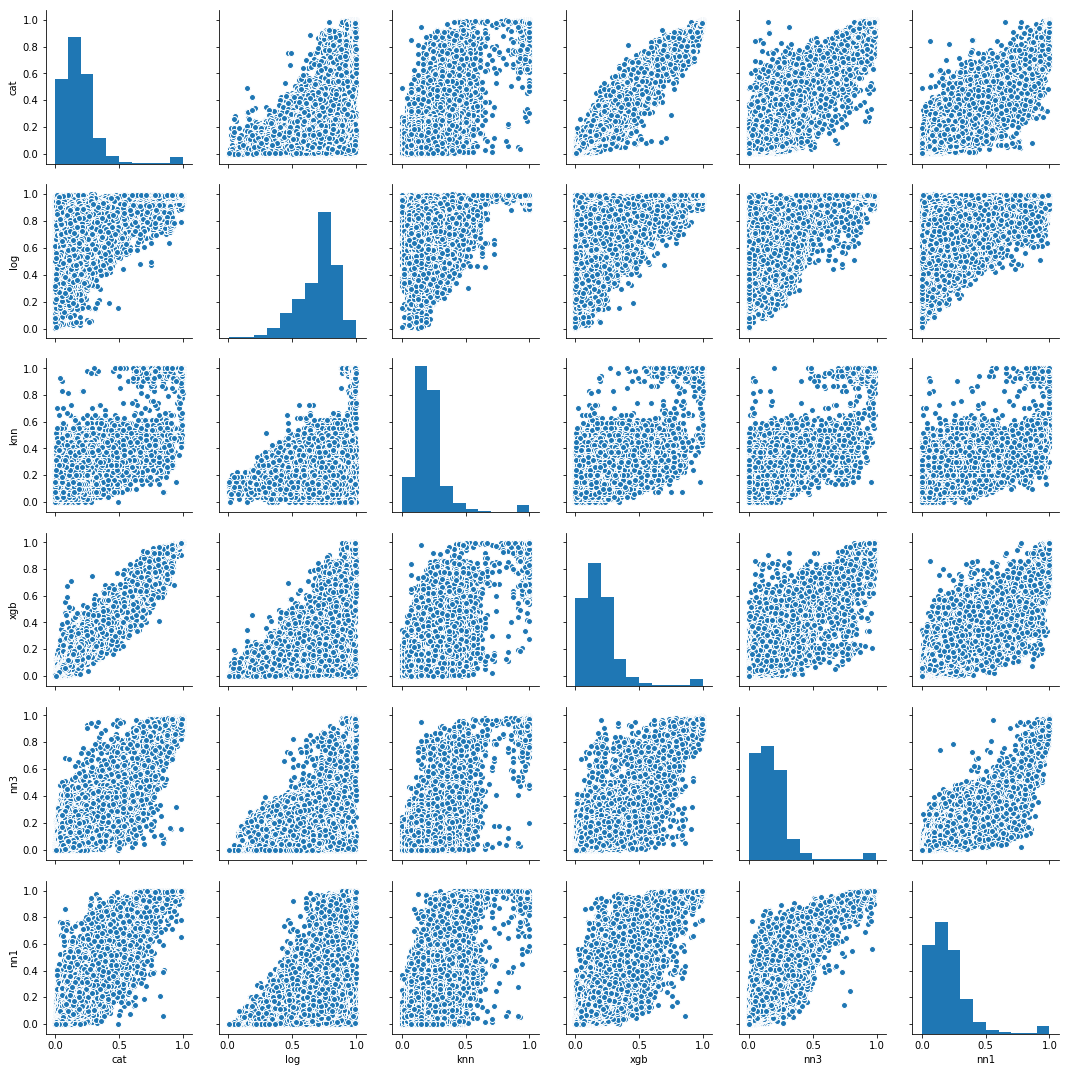

In [30]:
sns.pairplot(test_meta)

In [81]:
average_stack_output = pd.read_csv("testing-set.csv")
average_stack_output["deal_or_not"] = test_meta.mean(axis=1)
average_stack_output.to_csv("average_6model.csv", encoding="utf-8", index=False)

In [88]:
input_layer = Input(shape=(3, ))
hidden = Dense(2, activation="relu")(input_layer)
output_layer = Dense(1, activation="sigmoid")(hidden)
stack_perceptron = Model(input_layer, output_layer)
stack_perceptron.compile(optimizer="adam", loss="binary_crossentropy")
stack_perceptron.fit(train_meta, y_train, epochs=50, batch_size=256, shuffle=True)
stack_output = pd.read_csv("testing-set.csv")
stack_output["deal_or_not"] = stack_perceptron.predict(test_meta)[:, 0]
stack_output.to_csv("stack_output_v2.csv", encoding="utf-8", index=False)

Epoch 1/50
297020/297020 [==============================] - 2s 7us/step - loss: 0.5183
Epoch 2/50
297020/297020 [==============================] - 2s 6us/step - loss: 0.4645
Epoch 3/50
297020/297020 [==============================] - 2s 6us/step - loss: 0.4468
Epoch 4/50
297020/297020 [==============================] - 2s 5us/step - loss: 0.4375
Epoch 5/50
297020/297020 [==============================] - 2s 5us/step - loss: 0.4332
Epoch 6/50
297020/297020 [==============================] - 2s 6us/step - loss: 0.4310
Epoch 7/50
297020/297020 [==============================] - 2s 6us/step - loss: 0.4295
Epoch 8/50
297020/297020 [==============================] - 2s 5us/step - loss: 0.4285
Epoch 9/50
297020/297020 [==============================] - 2s 5us/step - loss: 0.4279
Epoch 10/50
297020/297020 [==============================] - 1s 5us/step - loss: 0.4274
Epoch 11/50
297020/297020 [==============================] - 1s 5us/step - loss: 0.4270
Epoch 12/50
297020/297020 [==============

In [70]:
# use catboost to be meta model
cat_params = {
    "learning_rate": 0.05,
    "iterations": 500,
    "random_seed": 104702016,
    "eval_metric": 'AUC',
    "logging_level": "Silent",
    "depth":2
}

stack_cat = CatBoostClassifier(**cat_params)
stack_cat.fit(train_meta, y_train)
stack_cat_output = pd.read_csv("testing-set.csv")
stack_cat_output["deal_or_not"] = stack_cat.predict_proba(test_meta)[:, 1]
stack_cat_output.to_csv("stack_output_v3.csv", encoding="utf-8", index=False)

In [34]:
stack_log = LogisticRegression(class_weight="balanced", C=0.01)
stack_log.fit(train_meta, y_train)
stack_log_output = pd.read_csv("testing-set.csv")
stack_log_output["deal_or_not"] = stack_log.predict_proba(test_meta)[:, 1]
stack_log_output.to_csv("stack_output_v7.csv", encoding="utf-8", index=False)